<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp?1" width="100px"></a>
</td>
</tr>
</table>

# Chapter 7: Finetuning To Follow Instructions

In [11]:
from importlib.metadata import version

pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.2
tiktoken version: 0.8.0
torch version: 2.5.1
tqdm version: 4.67.1
tensorflow version: 2.17.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/overview.webp?1" width=1000px>

## 7.1 Introduction to instruction finetuning

- 在第五章中，我们了解到对大语言模型（LLM）进行预训练涉及一个训练过程，在这个过程中它学习一次生成一个单词。
- 因此，一个经过预训练的大语言模型擅长文本补全，但不擅长遵循指令。
- 在本章中，我们将教导大语言模型更好地遵循指令。 

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/instruction-following.webp" width=800px>

- 本章所涵盖的主题总结在下面的图表中。 

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-1.webp?1" width=800px>

## 7.2 Preparing a dataset for supervised instruction finetuning

- 我们将使用我为本章准备的一个指令数据集来开展工作。 

In [12]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- 我们从上述 JSON 文件中加载的 `data` 列表中的每一项 都是一个具有以下形式的字典。 

In [13]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- Note that the `'input'` field can be empty:

In [14]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- 指令微调通常被称为“有监督的指令微调 supervised instruction finetuning”，因为它涉及在一个明确提供了输入-输出对的数据集上对模型进行训练。
- 有不同的方式来格式化条目，使其作为大语言模型（LLM）的输入；下面的图表分别展示了两种示例格式，它们曾被用于 Alpaca 大语言模型（https://crfm.stanford.edu/2023/03/13/alpaca.html）和 Phi-3 大语言模型（https://arxiv.org/abs/2404.14219）。  

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/prompt-style.webp?1" width=1000px>

- 在本章中，我们使用 Alpaca 风格的提示格式，这是用于指令微调的原始提示模板。
- 下面，我们对将作为输入传递给大语言模型（LLM）的内容进行格式化。 

In [15]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- 带有输入字段的格式化回复如下所示。 

In [16]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


- 下面是一个没有输入字段的格式化回复。 

In [17]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- 最后，在下一节准备 PyTorch dataloader 之前，我们将数据集划分为训练集、验证集和测试集。 

In [18]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [19]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 Organizing data into training batches

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-2.webp?1" width=800px>

- 我们分几个步骤来处理这个数据集批处理（dataset batching），如下图所示进行了总结。 

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/detailed-batching.webp?1" width=800px>

- 首先，我们实现了一个“指令数据集（InstructionDataset）”类，它会对数据集中的所有输入进行预分词（pre-tokenizes）处理，这与第6章中的“垃圾邮件数据集（SpamDataset）”类似。 

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/pretokenizing.webp" width=1000px>

In [20]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

- 与第六章类似，我们希望在一个批次中收集多个训练样本，以加速训练过程；这就需要将所有输入都填充到相近的长度。
- 同样与上一章类似，我们使用 `<|endoftext|>` 标记作为填充标记。 

In [21]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- 在第六章中，我们将数据集中的所有样本都填充到了相同的长度。
  - 在这里，我们采用一种更为复杂精细的方法，开发一个自定义的 “collate” 函数，并将其传递给数据加载器。
  - 这个自定义的 collate 函数会将每个批次中的训练样本填充到相同的长度（不过不同的批次可以有不同的长度）。 

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/padding.webp" width=800px>

In [22]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [23]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-4.webp?1" width=1000px>

- 上述内容中，我们只向大语言模型（LLM）输入了数据；然而，对于大语言模型的训练而言，我们还需要目标值。
- 与预训练大语言模型类似，目标值是将输入内容向右移动一个位置得到的，这样大语言模型就能学习预测下一个标记。 

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/inputs-targets.webp?1" width=800px>

In [24]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [25]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- 接下来，我们引入一个`ignore_index`值，用一个新的值来替换所有的填充（padding）标记 ID；这个`ignore_index`的目的是我们可以在损失函数中忽略填充值（关于这一点，稍后会详细介绍）。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-5.webp?1" width=800px>

- 具体来说，这意味着我们将与`50256`对应的标记 ID 替换为`-100`，如下所示。 

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ignore-index.webp?1" width=800px>

- （此外，我们还引入了`allowed_max_length`，以防我们想要限制样本的长度；如果你计划处理比 GPT-2 模型所支持的 1024 个标记的上下文长度还要长的自有数据集，这将会很有用。） 

In [26]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [27]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- 让我们看看用 -100 进行的这种替换能达成什么效果。
- 为了便于说明，我们假设我们有一个小型的分类任务，有两个类别标签，即 0 和 1，这与第 6 章的情况类似。
- 如果我们有以下的对数几率（logits）值（模型最后一层的输出），我们计算出以下的损失。 

In [28]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


- 现在，不出所料，再添加一个训练示例将会影响损失值。 

In [29]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


- 让我们看看如果我们将其中一个示例的类别标签替换为 -100 会发生什么情况。 

In [30]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- 正如我们所见，这 3 个训练示例的最终损失与我们从 2 个训练示例中计算出的损失相同，这意味着交叉熵损失函数忽略了标签为 -100 的那个训练示例。
- 默认情况下，PyTorch 有 `cross_entropy(..., ignore_index=-100)` 这样的设置，用于忽略与标签 -100 相对应的示例。
- 通过使用这个 -100 的 `ignore_index`，我们可以忽略批次中额外的文本结束（填充）标记，这些标记是我们用来将训练示例填充到等长时所使用的。
- 然而，我们并不想忽略第一个文本结束（填充）标记（50256）的实例，因为当大语言模型（LLM）的回复完成时，它可以起到提示作用。 

- In practice, it is also common to mask out the target token IDs that correspond to the instruction, as illustrated in the figure below (this is a recommended reader exercise after completing the chapter)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/mask-instructions.webp?1" width=1000px>

## 7.4 为指令数据集创建 data loaders

- 在本节中，我们使用 `InstructionDataset` 类和 `custom_collate_fn` 函数来实例化训练、验证和测试数据加载器。 

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-3.webp?1" width=500px>

- 之前的 `custom_collate_fn` 函数还有一个额外的细节，即我们现在直接将数据移动到目标设备（例如 GPU），而不是在主训练循环中进行这一操作。这样做可以提高效率，因为当我们将 `custom_collate_fn` 作为数据加载器的一部分使用时，该操作可以作为后台进程执行。
- 我们使用 Python 标准库 `functools` 中的 `partial` 函数，创建了一个新函数，该函数预先填充了原函数的 `device` 参数。 

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print("Device:", device)

Device: mps


In [32]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- 接下来，我们像前几章那样实例化数据加载器，不同的是，我们现在为批处理过程提供了自己的整理（collate）函数。 

In [33]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [34]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- 让我们看看最终得到的输入批次和目标批次的维度是什么样的。

In [35]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

- 从上面的输出我们可以看到，正如预期的那样，所有批次的批量大小均为 8，但长度不同。
- 让我们再通过打印 `inputs` 批次中第一个训练示例的内容，来再次确认输入是否包含与标记 ID 50256 对应的 `<|endoftext|>` 填充标记。 

In [36]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='mps:0')


- 同样地，我们通过肉眼检查来再次确认目标数据中包含 -100 占位标记。 

In [37]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='mps:0')


## 7.5 加载预训练 LLM

- 在本节中，我们使用与第 5 章第 5.5 节以及第 6 章第 6.4 节相同的代码来加载一个预训练的 GPT 模型。 

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-4.webp?1" width=800px>

- 然而，我们没有加载参数数量最少的 1.24 亿参数模型，而是加载了拥有 3.55 亿参数的中等版本模型，因为 1.24 亿参数的模型太小，通过指令微调难以取得质量上合理的结果。 

In [39]:
from gpt_download import download_and_load_gpt2_local
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2_local(
    model_size=model_size,
    models_dir="gpt2",
    local_only=False

)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 24.1kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 871kiB/s] 
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 21.4kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [09:45<00:00, 2.42MiB/s] 
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 2.10MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 648kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 470kiB/s] 


- 在我们在下一节开始对模型进行微调之前，让我们看看它在其中一个验证任务上的表现如何。

In [40]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [41]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

- 请注意，我们在前面几章中使用的 `generate` 函数会返回组合后的输入和输出文本，这在前面的章节中便于生成易读的文本。
- 为了分离出回复内容，我们可以从 `generated_text` 的起始位置减去指令的长度。 

In [42]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


- 正如我们所见，该模型目前还无法遵循指令；它创建了一个“回复”部分，但只是重复了原始输入句子以及指令内容。 

## 7.6 在指令数据上微调大语言模型（LLM）

- 在本节中，我们将对模型进行微调。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-5.webp?1" width=800px>

- 请注意，我们可以复用在前面几章中使用过的所有损失计算和训练函数。

In [43]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

- 让我们在开始训练之前计算初始的训练集和验证集损失（和前面几章一样，我们的目标是最小化损失）。 

In [44]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8259105682373047
Validation loss: 3.7619349479675295


- 请注意，由于我们使用了更大的模型（3.55 亿参数而非 1.24 亿参数），本次训练的成本比前几章的训练要高一些。
- 以下列出了在不同设备上的运行时间，以供参考（在兼容的 GPU 设备上运行此笔记本无需对代码进行修改）。 

<div style="text-align: left;">
    
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>

- I ran this notebook using the `"gpt2-medium (355M)"` model

In [45]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.800, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.809
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.535, Val loss 0.732
Ep 1 (Step 000075): Train loss 0.567, Val loss 0.736
Ep 1 (Step 000080): Train loss 0.602, Val loss 0.731
Ep 1 (Step 000085): Train loss 0.513, Val loss 0.715
Ep 1 (Step 000090): Train loss 0.571, Val loss

- 从上面的输出结果可以看出，模型训练效果良好，这可以从不断下降的训练损失和验证损失值判断出来。
- 此外，根据每个训练周期后打印的回复文本，我们可以看到模型能够正确遵循指令，将输入句子“厨师每天都烹饪这顿饭。”（The chef cooks the meal every day.）转换为 `被动语态` “这顿饭每天都被厨师烹饪。”（The meal is cooked every day by the chef.）（我们将在后面的章节中对回复进行正确格式化和评估）。
- 最后，让我们来看看训练损失和验证损失曲线。 

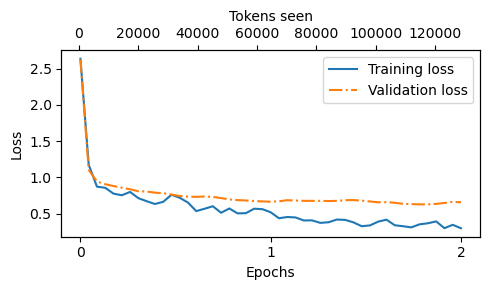

In [46]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 正如我们所见，在第一个训练周期开始时，损失急剧下降，这意味着模型快速开始学习。
- 我们可以看到，在大约 1 个训练周期时开始出现轻微的过拟合现象。 

## 7.7 提取并保存回复

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-6.webp?1" width=800px>

- 在本节中，我们保存测试集的回复，以便在下一节中进行评分。
- 我们还保存一份模型的副本，以备将来使用。
- 但首先，让我们简要查看一下微调（finetuned）模型生成的回复。 

In [47]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

- 正如我们从测试集的指令、给定的回复以及模型生成的回复中可以看到的，该模型表现得相对较好。
- 对于第一条和最后一条指令的答案显然是正确的。
- 第二个答案很接近；模型回答的是“积云（cumulus cloud）”，而不是“积雨云（cumulonimbus）”（不过，请注意积云可以发展成积雨云，而积雨云能够产生雷暴）。
- 最重要的是，我们可以看到，模型评估并不像前一章中那么简单直接，在前一章中我们只需计算正确的垃圾邮件/非垃圾邮件类别标签的百分比，就能得出分类准确率。
- 在实践中，像聊天机器人这样经过指令微调的大语言模型（LLM）是通过多种方法进行评估的：
  - 诸如MMLU（“大规模多任务语言理解评估”，[https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)）这样的简答题和选择题基准测试，用于测试模型的知识水平。
  - 与其他大语言模型（LLM）进行人类偏好比较，例如LMSYS聊天机器人竞技场（[https://arena.lmsys.org](https://arena.lmsys.org)）。
  - 自动化对话基准测试，即使用另一个像GPT-4这样的大语言模型（LLM）来评估回复，例如AlpacaEval（[https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/)）。

- 在下一节中，我们将使用一种类似于AlpacaEval的方法，并使用另一个大语言模型（LLM）来评估我们模型的回复；不过，我们将使用我们自己的测试集，而不是使用公开可用的基准数据集。
- 为此，我们将模型的回复添加到 `test_data` 字典中，并将其保存为一个名为“instruction-data-with-response.json”的文件，以便记录留存，这样如果有需要，我们可以在不同的Python会话中加载并分析它。 

In [48]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [02:33<00:00,  1.40s/it]


- 让我们再次检查其中一个条目，看看回复是否已正确添加到 `test_data` 字典中。 

In [51]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


- 最后，我们也保存模型，以防我们下一次想重新使用我们微调之后的模型

In [50]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## 7.8 评估经过微调的大语言模型（LLM）

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-7.webp?1" width=800px>

- 在本节中，我们使用另一个更大的大语言模型（LLM）来自动评估经过微调的大语言模型（LLM）的回复。
- 具体来说，我们使用由Meta AI开发的一个经过指令微调的、拥有80亿参数的Llama 3模型，该模型可以通过ollama（[https://ollama.com](https://ollama.com)）在本地运行。
- （或者，如果你更倾向于通过OpenAI API使用像GPT-4这样更强大的大语言模型（LLM），请查看[llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb)笔记本） 

- Ollama是一款能够高效运行大语言模型（LLM）的应用程序。
- 它是llama.cpp（[https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)）的一个封装程序，llama.cpp 使用纯C/C++ 实现大语言模型（LLM）以最大限度地提高效率。
- 请注意，它是一个用于使用大语言模型（LLM）生成文本（推理）的工具，而不是用于训练或微调大语言模型（LLM）的工具。
- 在运行下面的代码之前，请访问[https://ollama.com](https://ollama.com) 并按照说明安装Ollama（例如，点击“下载”按钮，然后为你的操作系统下载Ollama应用程序）。 

<!-- - For macOS and Windows users, click on the ollama application you downloaded; if it prompts you to install the command line usage, say "yes"
- Linux users can use the installation command provided on the ollama website

- In general, before we can use ollama from the command line, we have to either start the ollama application or run `ollama serve` in a separate terminal

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ollama-run.webp?1" width=700px>


- With the ollama application or `ollama serve` running in a different terminal, on the command line, execute the following command to try out the 8-billion-parameter Llama 3 model (the model, which takes up 4.7 GB of storage space, will be automatically downloaded the first time you execute this command)

```bash
# 8B model
ollama run llama3
```


The output looks like as follows

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- Note that `llama3` refers to the instruction finetuned 8-billion-parameter Llama 3 model

- Using ollama with the `"llama3"` model (a 8B parameter model) requires 16 GB of RAM; if this is not supported by your machine, you can try the smaller model, such as the 3.8B parameter phi-3 model by setting `model = "phi-3"`, which only requires 8 GB of RAM

- Alternatively, you can also use the larger 70-billion-parameter Llama 3 model, if your machine supports it, by replacing `llama3` with `llama3:70b`

- After the download has been completed, you will see a command line prompt that allows you to chat with the model

- Try a prompt like "What do llamas eat?", which should return an output similar to the following

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
``` -->

- 对于 macOS 和 Windows 用户，点击你下载的 Ollama 应用程序；如果它提示你安装命令行使用方式，请选择“是”。
- Linux 用户可以使用 Ollama 网站上提供的安装命令。

- 一般来说，在我们能够从命令行使用 Ollama 之前，我们必须启动 Ollama 应用程序，或者在一个单独的终端中运行 `ollama serve` 命令。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ollama-run.webp?1" width=700px>

- 在另一个终端中运行 Ollama 应用程序或 `ollama serve` 命令后，在命令行中执行以下命令，来试用拥有 80 亿参数的 Llama 3 模型（该模型占用 4.7GB 的存储空间，在你第一次执行此命令时，它将自动下载）。

```bash
# 80 亿参数模型
ollama run llama3
```

输出内容如下：

```
$ ollama run llama3
正在拉取清单
正在拉取 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
正在拉取 4fa551d4f938... 100% ▕████████████████▏  12 KB
正在拉取 8ab4849b038c... 100% ▕████████████████▏  254 B
正在拉取 577073ffcc6c... 100% ▕████████████████▏  110 B
正在拉取 3f8eb4da87fa... 100% ▕████████████████▏  485 B
正在验证 sha256 摘要
正在写入清单
正在移除所有未使用的层
成功
```

- 请注意，`llama3` 指的是经过指令微调的、拥有 80 亿参数的 Llama 3 模型。

- 使用带有 `"llama3"` 模型（一个 80 亿参数的模型）的 Ollama 需要 16GB 的内存；如果你的机器不支持，你可以尝试较小的模型，比如拥有 38 亿参数的 phi-3 模型，方法是设置 `model = "phi-3"`，该模型只需要 8GB 的内存。

- 或者，如果你的机器支持的话，你也可以使用更大的、拥有 700 亿参数的 Llama 3 模型，只需将 `llama3` 替换为 `llama3:70b` 即可。

- 下载完成后，你将看到一个命令行提示符，它允许你与该模型进行对话。

- 尝试输入一个类似 “美洲驼吃什么？” 这样的提示，它应该会返回类似以下的输出：

```
>>> 美洲驼吃什么？
美洲驼是反刍动物，这意味着它们有一个四室胃，并且食用高纤维的植物。在野外，美洲驼
通常以以下食物为食：
1. 草：它们喜欢啃食各种类型的草，包括高草、小麦、燕麦和大麦。
``` 

- 你可以输入 `/bye` 来结束这次会话。 

- 以下代码会在继续使用Ollama来评估我们在上一节中生成的测试集回复之前，检查Ollama会话是否正在正确运行。 

In [53]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [54]:
# This cell is optional; it allows you to restart the notebook
# and only run section 7.7 without rerunning any of the previous code
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- 现在，除了我们之前使用的 `ollama run` 命令来与模型进行交互之外，还有一种替代方法，即通过Python利用其REST API ，可通过以下函数来实现。
- 在运行此笔记本中的下一个代码单元之前，请确保Ollama仍在运行（之前的代码单元应该会打印出 `Ollama running: True`）。
- 接下来，运行以下代码单元来查询模型。 

In [58]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3.2"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily eat plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and grassy weeds.
2. Hay: High-quality hay, such as timothy hay or alfalfa hay, is a staple in a llama's diet. It provides essential nutrients like fiber, protein, and vitamins.
3. Grains: Llamas may also be fed grains like oats, barley, or corn, but these should not make up more than 10% of their diet.
4. Fruits and vegetables: Fresh fruits and vegetables, such as apples, carrots, and sweet potatoes, can be given to llamas as treats or added to their hay.
5. Browse: Llamas may also eat browse, which includes leaves, twigs, and other vegetation from trees and shrubs.

It's essential to note that llamas have a unique digestive system, with a four-chambered stomach, which allows them to break down and extract nutrients from plant material more efficiently than many other 

- 现在，利用我们上面定义的 `query_model` 函数，我们可以评估经过微调的模型的回复；让我们对前一节中查看过的前 3 条测试集回复进行尝试。 

In [59]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt, "llama3.2"))    # 我本地默认安装 llama3.2
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> To rewrite the sentence using a simile, we need to compare the speed of the car to something else.

Correct output: The car is as fast as lightning.

Score: 100

The model response "The car is as fast as a bullet" is close, but not perfect. A simile should use "like" or "as" to make the comparison, whereas "as fast as a bullet" implies that the car is literally a bullet, which isn't the intended meaning.

A better score for the model response would be around 80-90, as it's close to the correct form but not quite there.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.

Score:
>> I would rate the model response a 20.

The reason for this low score is that the model response contains an error in its classificatio

- 正如我们所见，Llama 3 模型给出了合理的评估，并且当模型的回答不完全正确时，也会给出部分分数，就像我们从“积云（cumulus cloud）”这个答案中看到的那样。
- 请注意，之前的提示会返回非常详细的评估内容；我们可以调整提示内容，使其生成 0 到 100 之间的整数评分（100 分表示最佳），以便为我们的模型计算平均得分。
- 在配备 M3 芯片的 MacBook Air 笔记本电脑上，对测试集中的 110 个条目进行评估大约需要 1 分钟。 

In [62]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only. You should not give any explaination on score. Only output an integer number"
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response", model="llama3.2")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:  22%|██▏       | 24/110 [00:07<00:33,  2.59it/s]

Could not convert score: Fish: Shark, Trout
Mammals: Dolphin

90


Scoring entries:  71%|███████   | 78/110 [00:25<00:17,  1.88it/s]

Could not convert score: I would classify the given sentence into two categories:

1. Declarative: 80
2. Interrogative: 60


Scoring entries:  95%|█████████▍| 104/110 [00:33<00:02,  2.76it/s]

Could not convert score: Hasta luego

Score: 0


Scoring entries:  98%|█████████▊| 108/110 [00:35<00:01,  1.80it/s]

Could not convert score: The classification of the sentence 'Please open the door.' is imperative.
Score: 100


Scoring entries: 100%|██████████| 110/110 [00:36<00:00,  3.03it/s]

Number of scores: 106 of 110
Average score: 55.99



- 我们的模型获得了超过 50 分的平均得分，我们可以将其作为参考点，用于将该模型与其他模型进行比较，或者尝试其他可能改进模型的训练设置。
- 请注意，截至撰写本文时，Ollama 在不同操作系统上并非完全具有确定性，因此你得到的分数可能会与上面显示的分数略有不同。 

- 作为参考，原始的：
  - Llama 3 80B 基础模型的得分为 58.51。
  - Llama 3 80B 指令模型的得分为 82.65。 

## 7.9 Conclusions

<details>
  <summary>英文原文</summary>

  ### 7.9.1 What's next

- This marks the final chapter of this book
- We covered the major steps of the LLM development cycle: implementing an LLM architecture, pretraining an LLM, and finetuning it

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/final-overview.webp?1" width=500px>

- An optional step that is sometimes followed after instruction finetuning, as described in this chapter, is preference finetuning
- Preference finetuning process can be particularly useful for customizing a model to better align with specific user preferences; see the [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) folder if you are interested in this

- This GitHub repository also contains a large selection of additional bonus material you may enjoy; for more information, please see the [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) section on this repository's README page

### 7.9.2 Staying up to date in a fast-moving field

- No code in this section

### 7.9.3 Final words

- I hope you enjoyed this journey of implementing an LLM from the ground up and coding the pretraining and finetuning functions
- In my opinion, implementing an LLM from scratch is the best way to understand how LLMs work; I hope you gained a better understanding through this approach
- While this book serves educational purposes, you may be interested in using different and more powerful LLMs for real-world applications
  - For this, you may consider popular tools such as axolotl ([https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)) or LitGPT ([https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt)), which I help developing

</details>

### 7.9.1 接下来的计划

- 这标志着本书的最后一章。
- 我们涵盖了大语言模型（LLM）开发周期的主要步骤：实现一个大语言模型架构、预训练一个大语言模型，以及对其进行微调。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/final-overview.webp?1" width=1000px>

- 正如本章所描述的，在指令微调之后，有时会进行的一个可选步骤是偏好微调。
- 偏好微调过程对于定制模型使其更好地符合特定用户偏好特别有用；如果你对此感兴趣，可以查看 [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) 文件夹。

- 这个 GitHub 存储库还包含大量你可能会感兴趣的额外补充材料；更多信息，请查看该存储库 README 页面上的 [补充材料](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) 部分。

### 7.9.2 在快速发展的领域中保持与时俱进

- 本节无代码内容。

### 7.9.3 结束语

- 我希望你享受了这次从头开始实现一个大语言模型（LLM），并为预训练和微调函数编写代码的旅程。
- 在我看来，从头开始实现一个大语言模型是理解大语言模型如何工作的最佳方式；我希望通过这种方式你能有更深入的理解。
- 虽然本书具有教育意义，但你可能有兴趣在实际应用中使用不同且更强大的大语言模型。
  - 为此，你可以考虑一些流行的工具，如 axolotl（[https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)）或 LitGPT（[https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt)），我也参与了这些工具的开发工作。 

<details>
  <summary>Original</summary>

  ## Summary and takeaways

- See the [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py) script, a self-contained script for classification finetuning
- [./ollama_evaluate.py](./ollama_evaluate.py) is a standalone script based on section 7.8 that evaluates a JSON file containing "output" and "response" keys via Ollama and Llama 3
- The [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) notebook illustrates how to load the finetuned model in a new session
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)

</details>




## 总结与要点

- 请查看 [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py) 脚本，这是一个用于分类微调的独立脚本。
- [./ollama_evaluate.py](./ollama_evaluate.py) 是一个基于 7.8 节的独立脚本，它通过 Ollama 和 Llama 3 对一个包含 “output” 和 “response” 键的 JSON 文件进行评估。
- [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) 笔记本展示了如何在新的会话中加载经过微调的模型。
- 你可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 中找到练习题的答案。 

## 接下来做什么？

- 恭喜你读完了这本书；如果你还在寻找更多的学习资源，我在这个 GitHub 仓库中添加了几个补充章节，你可能会感兴趣。
- 完整的补充材料列表可以在主 README 文件的 [补充材料](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) 部分查看。
- 在这里重点介绍一些我特别推荐的内容：
  1. [用于大语言模型校准的直接偏好优化（从头开始）](../04_preference-tuning-with-dpo/dpo-from-scratch.ipynb) 实现了一种流行的偏好微调机制，能让本章中的模型更符合人类偏好。
  2. [从头开始实现 Llama 3.2（独立笔记本）](../../ch05/07_gpt_to_llama/standalone-llama32.ipynb)，这是对 Meta AI 广受欢迎的 Llama 3.2 的从头开始实现，包括加载官方预训练权重；如果你还想做一些额外的实验，可以用 `Llama3Model` 类替换每一章中的 `GPTModel` 模型（应该可以直接一对一替换）。
  3. [将 GPT 转换为 Llama](../../ch05/07_gpt_to_llama) 包含逐步指导的代码，解释了 GPT-2 与各种 Llama 模型之间的区别。
  4. [理解嵌入层和线性层之间的区别](../../ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb) 是一个概念性的解释，说明了我们在大语言模型输入阶段使用的 PyTorch 中的 `Embedding` 层，在数学上等同于应用于独热编码数据的线性层。
- 祝你继续阅读愉快！ 